In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import random


In [2]:
conn = sqlite3.connect('data_std.db')
scripts = '''select * from credit_default_pred'''
data_std = pd.read_sql(scripts, conn)
data_std

,A105,A106,A116,A401,A509,A511,A517,A519,A609,A611,A704,A705,B631,CCFA,CFCL,CFTL,CPAX,CPAY,DIR%,DIRT,EVA2,FITB,FJ01,MMTG,MTG%,R105,R106,R107,R108,R109,R110,R111,R117,R131,R132,R133,R135,R136,R138,R139,...,R51V,R522,R524,R527,R528,R529,R532,R607,R609,R611,R614,R615,R61D,R61E,R61F,R61G,R621,R622,R623,R624,R631,R632,R633,R674,R675,R677,R689,R801,R902,R903,R906,SUD1,T310,XCNL,XCPA,XCTL,XGRP,XMTG,XPYR,是否違約
0,0.155906,0.010461,-0.401397,-0.046266,0.334499,-0.142139,-0.087050,0.294049,-0.404180,-0.013853,2.447597,-0.453582,-0.440178,-0.460932,-0.244067,-0.207594,3.893911,-0.321297,-0.515479,-0.522510,0.254609,-0.279285,0.059248,-0.881211,-0.880617,-0.303119,0.254609,0.226461,0.191745,0.191745,0.470123,0.330050,0.983447,-0.892029,-0.753482,0.220765,1.162235,0.069244,1.857545,-0.211551,...,1.926890,-0.134034,-0.677214,-0.677894,0.185791,-0.417107,0.119334,-0.690101,-0.888460,0.505624,0.507196,0.398790,-0.851613,0.400189,-0.668481,0.091804,0.132302,0.854379,-0.936932,0.288015,-1.037038,0.448115,0.398254,-0.388186,-0.182883,0.400953,0.409477,3.484295,-1.296642,-0.179829,1.216554,0.150698,2.683424,-0.377492,-0.135021,-1.164123,-0.662574,-0.795279,-0.114314,0.0
1,0.082568,0.010461,-0.430237,0.006949,0.437604,-0.142139,-0.090957,0.392044,-0.412637,-0.014003,3.298513,-0.494750,-0.440303,-0.460932,-0.427307,-0.420270,3.893911,-0.321297,-0.526408,-0.533250,0.251186,-0.279285,0.059248,-0.457556,-0.336195,-0.350555,0.251186,0.227559,0.194512,0.194512,-0.084670,-0.012915,1.252205,-0.671488,-0.728012,0.103822,1.219639,0.030799,1.761647,-0.153488,...,1.970367,-0.134034,-0.556533,-0.614095,0.007441,-0.408655,0.144286,-0.595821,-0.914414,0.365656,0.415605,0.268571,-0.809385,0.211368,-0.609871,0.042456,0.068932,0.710887,-0.936932,0.296244,-1.037362,0.365801,0.315920,-0.423921,-0.184576,0.376555,0.430843,3.627420,-1.273895,-0.187247,1.443770,0.205122,2.886790,2.649062,-0.135021,-1.145749,1.423786,-0.795279,-0.114314,0.0
2,0.096319,0.010461,-0.427540,-0.012908,0.707057,-0.142139,-0.090957,0.648142,-0.415240,-0.014008,3.404488,-0.484047,-0.446741,-0.460932,-0.362960,-0.349096,3.893911,-0.321297,-0.515479,-0.521878,0.230933,-0.279285,0.059248,-0.455223,-0.333197,-0.343950,0.230933,0.200938,0.149020,0.149020,0.607914,0.126367,1.221220,-0.393090,-0.718579,-0.060861,1.512272,-0.026710,1.629476,-0.244729,...,2.035880,-0.134034,-0.322473,-0.673140,0.015085,-0.419602,0.113560,-0.633533,-0.922237,0.361298,0.559720,0.242321,-0.834722,0.175759,-0.668481,0.023951,0.128575,0.740575,-0.936932,0.419687,-1.054021,0.382654,0.331968,-0.266560,-0.102633,0.704652,0.333008,3.873914,-1.273895,-0.179829,1.300948,0.259546,3.034055,2.649062,-0.135021,-1.145749,1.423786,-0.795279,-0.114314,0.0
3,0.371911,0.010463,-0.363939,-0.065520,1.092298,-0.142139,-0.065388,1.014289,-0.418615,-0.013812,3.815919,-0.442055,-0.450879,-0.460932,-0.304153,-0.281862,3.893911,-0.321297,-0.519979,-0.526932,0.364721,-0.279285,0.059248,-0.524326,-0.421999,-0.001090,0.364721,0.330750,0.257525,0.257524,1.679921,0.421157,1.423968,-0.379555,-0.725025,-0.166416,2.063049,-0.072146,1.653824,-0.276526,...,2.208000,-0.134034,-0.203149,-0.650423,0.083735,-0.419662,0.178725,-0.803237,-0.932668,0.539420,0.977643,0.361192,-0.910733,0.167057,-0.824775,0.057877,0.380192,0.997871,-0.936932,0.641884,-1.064838,0.569307,0.518116,-0.213270,-0.028703,1.073412,0.326261,4.144262,-0.299247,-0.187247,1.239275,0.313970,3.041067,2.649062,-0.135021,-0.358445,1.771513,-0.795279,-0.114314,0.0
4,0.568435,0.010464,-0.386761,-0.014787,1.312830,-0.142139,-0.026679,1.223891,-0.421827,-0.013747,4.429950,-0.462040,-0.451757,-0.460932,-0.450105,-0.448401,3.893911,-0.321297,-0.519979,-0.526932,0.414642,-0.279285,0.059248,-0.540071,-0.442232,0.222280,0.414642,0.374935,0.295332,0.295332,1.089197,0.039147,1.598425,-0.084173,-0.707731,-0.309638,2.191688,-0.125524,1.524634,-0.257171,...,2.249095,-0.134034,0.065332,-0.691104,-0.022992,-0.425424,0.215845,-0.840949,-0.942478,0.600002,1.126116,0.400396,-0.919178,0.099911,-0.863848,0.020866,0.441699

In [3]:
len(np.where(data_std['是否違約']==1)[0])

121

## Train/Test Split
- Test/Train ratio = 0.7

In [57]:
from sklearn.model_selection import train_test_split
X = data_std.loc[:,data_std.columns.difference(['是否違約'])]
y = data_std['是否違約']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
len(np.where(y_train==1)[0])

82

## 重複抽樣 + Few shot learning
本研究採用bagging的方式來建立MLP模型<br>
bagging->組合不同樣本訓練出來的模型後，再將預測值取平均<br>
違約資料有樣本不平衡之問題(1僅占樣本的1%)，重複抽樣的方式還需穩定每組樣本0和1之比例(固定70%/30%)<br>


In [375]:
# 產生亂數組
# n_task = 100
# n_meta_update = 100
# seeds_set = np.zeros((100,100))
# for i in range(100):
#     seeds = np.random.choice(10000000, 100)
#     seeds_set[i] = seeds
# np.save('seed_sets', seeds_set)

In [524]:
# 讀取預先製作的亂數組
seed_sets = np.load('seed_sets.npy')
seed_sets = seed_sets.astype(int)
# seed_sets = seed_sets.reshape(100*100)

In [649]:
def chose_one_class(random_state, train_X, train_y, way, n_shot):
    # 每個 way 抽出 n_shot 筆資料
    np.random.seed(random_state)
    rand_index = np.random.choice(np.where(train_y==way)[0], n_shot)
    return train_X.iloc[rand_index]

def build_task_sample(random_state, train_X, train_y, ways, n_shot):
    # 建立 task 資料
    task = np.zeros((1, len(ways), n_shot, len(train_X.columns)))
    for i in range(len(ways)):
        x = chose_one_class(random_state, train_X, train_y, ways[i], n_shot)
        task[0][i] = x
    return task

def generate_multiple_tasks(random_state, n_task, train_X, train_y, ways, n_shot):
    # 建立 task set:(n_task, n_ways, n_shot, n_features)
    task_sets = np.zeros((n_task, len(ways), n_shot, len(train_X.columns)))
    for i in range(n_task):
        task = build_task_sample(random_state[i], train_X, train_y, ways, n_shot)
        task_sets[i] = task
    y = np.zeros((n_task, len(ways), n_shot, len(ways)))
    y[:,:,:,:] = [0, 1]
    return task_sets, y

def create_model():
    # 清除背景中沒在使用的 model
    tf.keras.backend.clear_session()
    # model 為 3 層之 MLP
    # set initial weights of model
    initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, input_shape=(2,5,114), activation='relu', kernel_initializer=initializer))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Activation('softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model


def train_step(seed_sets, model, n_task, train_X, train_y, ways, n_shot, inner_lr=0.001, n_iteration = 1, outer_lr=0.01):
    for i in range(n_iteration):
        task_sets, y_true = generate_multiple_tasks(seed_sets[i], n_task, train_X, train_y, ways, n_shot)
        with tf.GradientTape(persistent=True) as outer_tape:
            task_loss = 0
            for i in range(task_sets.shape[0]):
                with tf.GradientTape(persistent=True) as inner_tape:
                    # 調整維度以符合模型的輸入
                    x = task_sets[i].reshape((1, *task_sets[i].shape))
                    y = y_true[i].reshape((1, *y_true[i].shape))
                    y_pred = model(x)
                    # 給定預測值(y_pred)和實際值(y)，用以計算loss
                    loss = tf.keras.losses.BinaryCrossentropy()(y, y_pred)
                grads = inner_tape.gradient(loss, model.trainable_variables)
                updated_weights = [w - inner_lr*g for w, g in zip(model.trainable_variables, grads)]
                y_pred = model(x, training=True)
                task_loss += tf.keras.losses.BinaryCrossentropy()(y, y_pred)
            task_loss /= task_sets.shape[0]
        outer_grads = outer_tape.gradient(task_loss, model.trainable_variables)
        updated_weights = [w - g for w, g in zip(model.trainable_variables, outer_grads)]
    return updated_weights, task_loss

In [661]:
task_sets, y = generate_multiple_tasks(seed_sets[1], 100, X_train, y_train, [0, 1], 5)
task_sets.shape, y.shape

((100, 2, 5, 114), (100, 2, 5, 2))

In [662]:
task_sets

array([[[[-3.76943222e-01,  1.04574210e-02, -3.56861826e-01, ...,
          -6.62573508e-01, -7.95278665e-01, -1.14314250e-01],
         [-4.58303026e-01,  1.04573136e-02, -1.25182208e-01, ...,
           7.28332912e-01, -7.95278665e-01,  4.43900982e+00],
         [-7.38478689e-01,  1.04551572e-02,  6.80881835e-01, ...,
          -6.62573508e-01, -7.95278665e-01, -1.14314250e-01],
         [-1.14355884e+00,  1.04534186e-02, -4.65142679e-01, ...,
          -6.62573508e-01,  7.81183051e-01, -1.14314250e-01],
         [-8.21557363e-01,  1.04588691e-02, -5.70005149e-01, ...,
           2.11923933e+00, -7.95278665e-01, -1.14314250e-01]],

        [[ 2.84536339e+00,  1.04631062e-02,  6.80285796e-02, ...,
          -6.62573508e-01,  2.06477525e+00, -1.14314250e-01],
         [-2.29348227e+00,  1.04344055e-02, -4.41262153e-01, ...,
           1.42378612e+00, -7.95278665e-01, -1.14314250e-01],
         [-1.77954041e+00,  1.04333711e-02, -5.50361491e-01, ...,
           2.46696594e+00, -7.952786

In [520]:
model = create_model()
new_weight, avg_task_loss = train_step(model, task_sets, y)
new_weight

In [658]:
new_weight

[<tf.Tensor: shape=(114, 64), dtype=float32, numpy=
 array([[-1.0999181 , -0.82243365, -1.332937  , ..., -0.39361918,
          3.080324  ,  0.01207277],
        [-0.90216786, -0.44586435, -1.2573415 , ..., -0.8475797 ,
         -0.6959568 ,  0.3314349 ],
        [ 1.7297285 , -0.24952687,  0.03084223, ...,  0.22021692,
         -0.35827458,  0.89064103],
        ...,
        [-0.9871149 ,  0.66721165,  1.5546188 , ..., -0.06298015,
         -1.3412077 ,  1.1866832 ],
        [-0.7443615 , -0.33762443, -0.6808694 , ...,  0.22088575,
          1.1030357 , -1.0324754 ],
        [-2.3616712 ,  2.5758657 , -0.94609743, ..., -0.65285534,
         -1.8362176 , -1.4062238 ]], dtype=float32)>,
 <tf.Tensor: shape=(64,), dtype=float32, numpy=
 array([-1.3570692e-03, -6.4099865e-04, -1.1628452e-03, -5.7082833e-03,
         4.8217853e-03, -6.1615491e-03,  1.3062399e-02, -3.8684451e-04,
         1.2708700e-03, -2.2405188e-03, -1.9712118e-03, -7.0696799e-03,
        -1.7874066e-02, -1.4146400e-03,  

In [651]:
new_weight, avg_task_loss = train_step(seed_sets, model, 100, X_train, y_train, [0,1], 5, n_iteration = 100)

In [652]:
# 創建一個空模型，在把訓練好的 weights 灌入模型中
empty_model = create_model()
model.set_weights(new_weight)

In [653]:
np.random.seed(99)
val_index = np.random.choice(X_train.index, 3000)
X_val = X_train.loc[val_index,:]
y_val = y_train.loc[val_index]

In [654]:
X_val = X_val.values.reshape((300, 2, 5, 114))
y_val = y_val.values.reshape(3000)
query_pred =model.predict(X_val)
# y_pred = np.where(query_pred>0.5, 1, 0)
pred_class = np.argmax(query_pred.reshape((3000,2)), axis=1)
pred_class

10/10 [==============================] - 0s 1ms/step


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [657]:
query_pred

array([[[[5.1010471e-19, 9.9999994e-01],
         [4.3465798e-18, 9.9999994e-01],
         [2.2834337e-10, 9.9999994e-01],
         [1.3654554e-17, 9.9999994e-01],
         [4.3422019e-19, 9.9999994e-01]],

        [[3.9110525e-17, 9.9999994e-01],
         [3.7654177e-23, 9.9999994e-01],
         [4.4000037e-15, 9.9999994e-01],
         [1.6864576e-12, 9.9999994e-01],
         [5.1467796e-21, 9.9999994e-01]]],


       [[[1.5012059e-23, 9.9999994e-01],
         [4.8436738e-10, 9.9999994e-01],
         [1.5595643e-11, 9.9999994e-01],
         [4.5723220e-19, 9.9999994e-01],
         [6.2376165e-20, 9.9999994e-01]],

        [[1.0846218e-20, 9.9999994e-01],
         [6.0158978e-10, 9.9999994e-01],
         [3.0245349e-24, 9.9999994e-01],
         [2.2795773e-22, 9.9999994e-01],
         [6.1096746e-11, 9.9999994e-01]]],


       [[[2.2548463e-11, 9.9999994e-01],
         [2.3939934e-15, 9.9999994e-01],
         [1.5134042e-12, 9.9999994e-01],
         [0.0000000e+00, 9.9999994e-01],
    

In [655]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
def plot_confusion_matrix(y_train, y_predict):
    conf_matrix= confusion_matrix(y_train, y_predict)
    LABELS=['Non_Fraud','Fraud'] #給出類別名稱
    plt.figure(figsize=(8,8))
    sns.heatmap(conf_matrix,xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Predicted class")
    plt.xlabel("True class")
    plt.show()

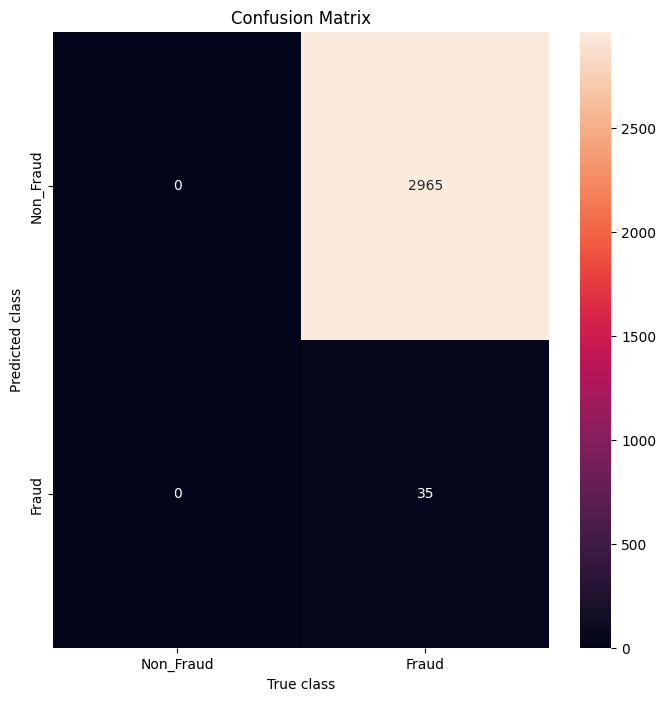

In [656]:
plot_confusion_matrix(y_val, pred_class)

## Loss analysis

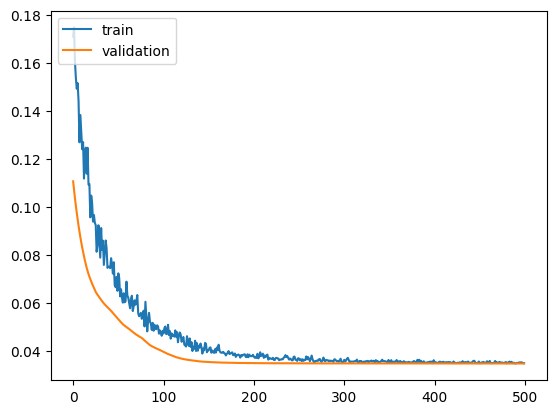

In [477]:
plt.plot(result.history['loss'], label = 'train')
plt.plot(result.history['val_loss'], label = 'validation')
plt.legend(loc = 2)

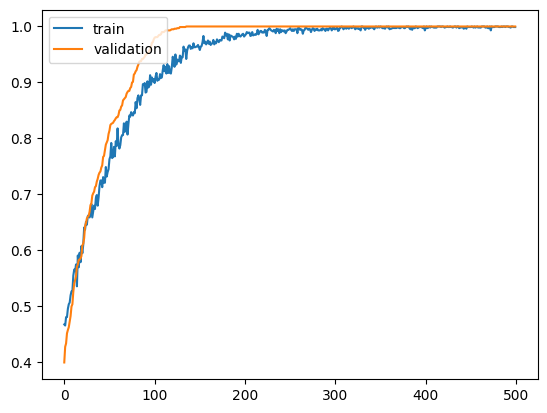

In [478]:
plt.plot(result.history['binary_accuracy'], label = 'train')
plt.plot(result.history['val_binary_accuracy'], label = 'validation')
plt.legend(loc = 2)

(600,)